In [11]:
"""Imports"""
import pandas as pd
import matplotlib.pyplot as plt

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

In [12]:
"""Load data from a CSV file into a PandasDataset"""
data = pd.read_csv("../Data/SANDIEGO.csv",
    index_col=0,
    parse_dates=True,
)
dataset = PandasDataset(data, target="SAND706URN")

In [13]:
"""Split data, train and make predictions"""
training_data, test_gen = split(dataset, offset=-12)
test_data = test_gen.generate_instances(prediction_length=4, windows=3)

# Train the model and make predictions
model = DeepAREstimator(
    prediction_length=12, freq="M", trainer_kwargs={"max_epochs": 5}
).train(training_data)

forecasts = list(model.predict(test_data.input))

/home/poppop/.local/lib/python3.10/site-packages/gluonts/time_feature/_base.py:249: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)
/home/poppop/.local/lib/python3.10/site-packages/gluonts/time_feature/lag.py:104: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/poppop/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | Mode  | In sizes                                                   | Out sizes   
--------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 23.3 K | 

Epoch 0: |          | 50/? [00:01<00:00, 29.71it/s, v_num=3, train_loss=2.330]

Epoch 0, global step 50: 'train_loss' reached 2.33446 (best 2.33446), saving model to '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-510 Machine learning: Fundamentals and Applications/Week 7/su25-aai510-group1/Notebooks/lightning_logs/version_3/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 34.29it/s, v_num=3, train_loss=1.400]

Epoch 1, global step 100: 'train_loss' reached 1.39958 (best 1.39958), saving model to '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-510 Machine learning: Fundamentals and Applications/Week 7/su25-aai510-group1/Notebooks/lightning_logs/version_3/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 35.49it/s, v_num=3, train_loss=1.150]

Epoch 2, global step 150: 'train_loss' reached 1.14759 (best 1.14759), saving model to '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-510 Machine learning: Fundamentals and Applications/Week 7/su25-aai510-group1/Notebooks/lightning_logs/version_3/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 35.63it/s, v_num=3, train_loss=1.010]

Epoch 3, global step 200: 'train_loss' reached 1.01323 (best 1.01323), saving model to '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-510 Machine learning: Fundamentals and Applications/Week 7/su25-aai510-group1/Notebooks/lightning_logs/version_3/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:01<00:00, 33.34it/s, v_num=3, train_loss=0.859]

Epoch 4, global step 250: 'train_loss' reached 0.85893 (best 0.85893), saving model to '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-510 Machine learning: Fundamentals and Applications/Week 7/su25-aai510-group1/Notebooks/lightning_logs/version_3/checkpoints/epoch=4-step=250.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: |          | 50/? [00:01<00:00, 33.19it/s, v_num=3, train_loss=0.859]


/home/poppop/.local/lib/python3.10/site-packages/gluonts/time_feature/lag.py:104: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)


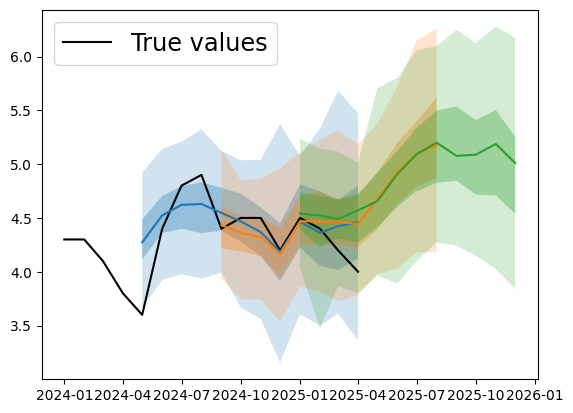

In [14]:
"""Plot predictions"""
plt.plot(data["2024":], color="black")
for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="xx-large")
plt.show()

Add robustness: [Link](https://www.geeksforgeeks.org/deepar-forecasting-algorithm/)